# Laboratório 13: Modelo Predador-Presa

### Referente ao capítulo 22

Vamos estudar um simples modelo predador-presa com uma restrição isoperimétrica. Considere o modelo de Lotka-Volterra 

\begin{gather}
    N_1'(t) = (\alpha_1 - \beta_1 N_2(t))N_1(t), N_1(0) = N_{10} \\ 
    N_2'(t) = (\beta_2 N_1(t) - \alpha_2)N_2(t), N_2(0) = N_{20}, 
\end{gather}

onde $N_1$ é a população presa e $N_2$ é a população predadora. Sejam $\alpha_1, \alpha_2, \beta_1, \beta_2 > 0$. Queremos estudar uma situação em que a presa age como peste e queremos reduzir essa população com uso de um agente químico ou biológico. Gostaríamos que o pesticida utilizado afetasse apenas as pestes, não deixa resíduo e mata dependente da densidade. Vamos supor os últimos dois itens, apesar de saber que são irrealistas. 

Seja $u(t)$ a taxa de aplicação de um pesticida que mate peste e predador. Assim, se $d_1$ e $d_2$ os parâmetros de densidade, 

\begin{gather}
    N_1'(t) = (\alpha_1 - \beta_1 N_2(t))N_1(t) - d_1N_1(t)u(t), N_1(0) = N_{10} > 0\\ 
    N_2'(t) = (\beta_2 N_1(t) - \alpha_2)N_2(t) - d_2N_2(t)u(t), N_2(0) = N_{20} > 0. 
\end{gather}

Nosso objetivo é 

$$
\min_u N_1(T) + \frac{A}{2}\int_0^T u(t)^2 dt, 
$$

e que tenhamos as restrições 

$$
0 \le u(t) \le M, \int_0^T u(t) dt = B, 
$$

isto é, temos restrição ambiental ou econômica que limita o uso de pesticida. 

Vamos supor $\alpha_1 = \alpha_2 = \beta_1 = \beta_2 = 1$ por simplicidade. 

Note que devemos ter $B = \int_0 ^T u(t) dt \le \int_0^T M dt = MT$. Também observe que a integral de $u^2$ deve ser minimizada, enquanto a integral de $u$ é fixa. Este funcional objetivo penaliza valores excessivamente grandes e encoraja valores pequeno mais distribuídos. Além disso, por motivos práticos isso facilita as contas. 

Para resolver o problema numericamente, seja a variável $z(t)$ com $z' = u, z(0) = 0, z(T) = B$. O método forward-backward sweep adaptado pode resolver esse tipo de problema, com apenas um valor fixado. A escolha dos valores iniciais $x_0$ e $x_1$ devem ser consideradas de forma a acelerar a convergência. Por isso, alguns testes são importantes. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import sympy as sp

import sys  
sys.path.insert(0, '../pyscripts/')

from optimal_control_class import OptimalControl

## Condições necessárias 

Mais uma vez vamos utilizar a biblioteca simbólica para nos ajudar nos cálculos. Note que esse sistema é tão simples que de fato não seria muito necessário, mas vamos usar assim mesmo. 

### Hamiltoniano

In [2]:
N1, N2, z, u, l1, l2, l3, d1, d2, A = sp.symbols('N_1 N_2 z u lambda_1 lambda_2 lambda_3 d_1 d_2 A')
H = 0.5*A*u**2 + l1*((1 - N2)*N1 - d1*N1*u) + l2*((N1 - 1)*N2 - d2*N2*u) + l3*u
H

0.5*A*u**2 + lambda_1*(-N_1*d_1*u + N_1*(1 - N_2)) + lambda_2*(-N_2*d_2*u + N_2*(N_1 - 1)) + lambda_3*u

### Condições do Estado

In [3]:
print(sp.diff(H,l1))
print(sp.diff(H,l2))
print(sp.diff(H,l3))

-N_1*d_1*u + N_1*(1 - N_2)
-N_2*d_2*u + N_2*(N_1 - 1)
u


### Equaçãoes Adjuntas

In [4]:
dl1 = (-1)*sp.diff(H,N1)
dl2 = (-1)*sp.diff(H,N2)
dl3 = (-1)*sp.diff(H,z)
print(dl1)
print(dl2)
print(dl3)

-N_2*lambda_2 - lambda_1*(-N_2 - d_1*u + 1)
N_1*lambda_1 - lambda_2*(N_1 - d_2*u - 1)
0


### Transversalidade 

$\lambda_1(T) = \phi_{N_1} = 1$

$\lambda_2(T) = \phi_{N_2} = 0$

$\lambda_3(T)$ livre

### Otimalidade

In [5]:
psi = sp.diff(H,u)
psi

1.0*A*u - N_1*d_1*lambda_1 - N_2*d_2*lambda_2 + lambda_3

Como temos um problema de minimização, temos que 

$$
H_u > 0 \implies u^*(t) = 0 \implies \frac{1}{A}(N_1 d_1 \lambda_1 + N_2 d_2 \lambda_2 - \lambda_3) < 0 
$$
$$
H_u < 0 \implies u^*(t) = M \implies \frac{1}{A}(N_1 d_1 \lambda_1 + N_2 d_2 \lambda_2 - \lambda_3) > M 
$$
$$
H_u = 0 \implies 0 \le u^*(t) = \frac{1}{A}(N_1 d_1 \lambda_1 + N_2 d_2 \lambda_2 - \lambda_3) \le M 
$$

Portanto $u^*(t) = \min\{M, \max\{0, \frac{1}{A}(N_1 d_1 \lambda_1 + N_2 d_2 \lambda_2 - \lambda_3) \}\}$

## Função de Plot

In [16]:
def plotting(t, x, u, ax = None, label = ''): 

    if not ax: 
        fig, ax = plt.subplots(3,1, figsize = (10, 8), sharex = True)
        
        ax[0].set_ylabel('Presa')
        ax[1].set_ylabel('Predador')
        ax[2].set_ylabel('Controle')
    
        for i in range(3):
            ax[i].grid(alpha = 0.5)

    ax[0].plot(t, x[:,0], label = label)
    ax[1].plot(t, x[:,1], label = label)
    ax[2].plot(t, u, label = label)
        
    return fig, ax

## Aplicando a classe ao exemplo 

Nesse exemplo temos uma dificuldade adicional. Temos um termo payoff linear, que pode ser lidado com o algoritmo até então, mas temos o tempo final de $z$ fixado. O algoritmo forward backward não lida com esse problema diretamente, então precisamos fazer a conexão com o método secante através da função $V$. Para isso vamos usar algumas facilitações que a classe nos dá. Podemos passar os valores de $theta$ através de uma lista de parâmetros e também podemos passar os estados com essas condições diferentes. 

Primeiro definimos os parâmetros do problema. Como $\lambda_3(T)$ é livre, colocamos que ele é `np.nan`, mas na verdade temos que lidar com esse problema utilizando o parâmetro `theta_list`. 

In [7]:
parameters = {'d1': None, 'd2': None, 'M': None, 'A': None, 'B': None}

diff_state = lambda t, x, u, par: np.array([
    -x[0]*par['d1']*u[0] + x[0]*(1 - x[1]), 
    -x[1]*par['d2']*u[0] + x[1]*(x[0] - 1), 
    u[0]
])

diff_lambda = lambda t, x, u, lambda_, par: np.array([
    -x[1]*lambda_[1] - lambda_[0]*(-x[1] - par['d1']*u[0] + 1), 
    x[0]*lambda_[0] - lambda_[1]*(x[0] - par['d2']*u[0] - 1), 
    0
])

update_u = lambda t, x, l, par: np.minimum(par['M'], \
        np.maximum(0, (1/par['A'])*(x[0]*par['d1']*l[0] + x[1]*par['d2']*l[1] - l[2])))

diff_phi = lambda x, par: np.array([1, 0, np.nan])

Vamos definir nossa função $V$. 

In [8]:
problem = OptimalControl(diff_state, diff_lambda, update_u, 
                         n_controls = 1, n_states = 3, diff_phi = diff_phi, 
                         free_adj_final = [2])

def V(theta, x0, T, par):
    _,x,_,_ = problem.solve(x0, T, par, bounds = [(0, par['M'])], theta_list = [theta])
    z = x[:,2]
    return z[-1] - par['B']

Por fim podemos definir a função que encontra as raízes da função $V$. Vamos definir $a$ e $b$ como os valores iniciais da sequência para o método de encontrar raízes. 

In [9]:
f_theta = lambda x0, T, par, a, b: root_scalar(f = V, 
                                               args = (x0,T,par), 
                                               method = 'secant',
                                               x0 = a, 
                                               x1 = b,
                                               )

Com essas definições, podemos aplicar ao problema. 

In [10]:
x0 =  np.array([10, 1, 0])
T = 10
parameters['d1'] = 0.1
parameters['d2'] = 0.1
parameters['M'] = 1
parameters['A'] = 1
parameters['B'] = 5
a = -0.52
b = -0.5

array([<AxesSubplot:ylabel='Presa'>, <AxesSubplot:ylabel='Predador'>,
       <AxesSubplot:ylabel='Controle'>], dtype=object)

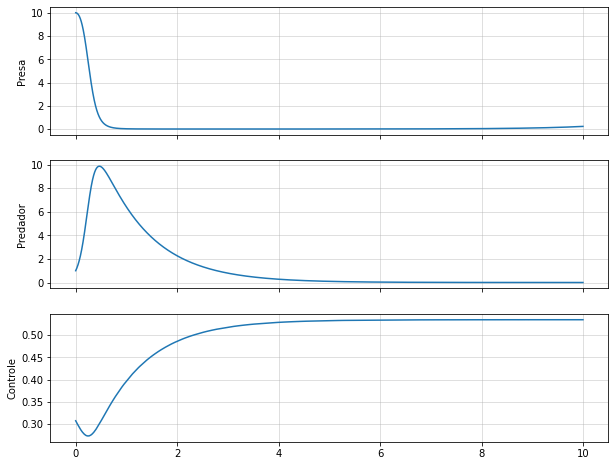

In [13]:
theta = f_theta(x0, T,parameters,a,b).root
t,x,u,_ = problem.solve(x0, T, parameters, 
                              bounds = [(0, parameters['M'])], theta_list = [theta])
fig, ax = plotting(t, x, u)

Vemos que nessa simulação, presa e predator são praticamente eliminadas. Inicialmente a população de predador aumenta, mas conforme o regime de pesticida cresce, a população de presa cai, levando os predadores da mesma forma. Claro que nesse caso a taxa com que o pesticida mata predador e presa é a mesma ($d_1 = d_2$), o que não é realista. Assim seja: 

array([<AxesSubplot:ylabel='Presa'>, <AxesSubplot:ylabel='Predador'>,
       <AxesSubplot:ylabel='Controle'>], dtype=object)

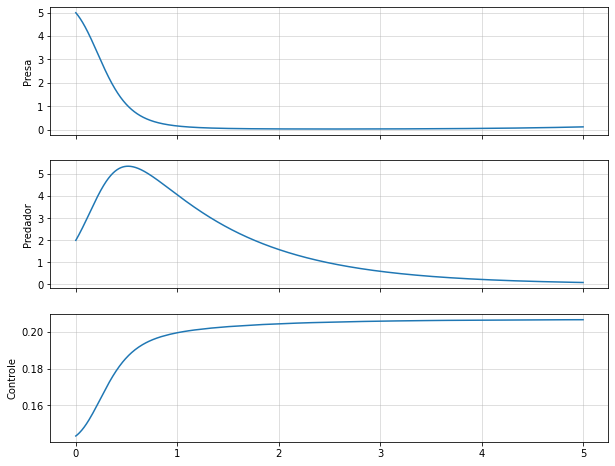

In [14]:
x0 =  np.array([5, 2, 0])
T = 5
parameters['d1'] = 0.1
parameters['d2'] = 0.01
parameters['M'] = 1
parameters['A'] = 1
parameters['B'] = 1
a = -0.2
b = -0.18

theta = f_theta(x0, T,parameters,a,b).root
t,x,u,_ = problem.solve(x0, T, parameters, 
                              bounds = [(0, parameters['M'])], theta_list = [theta])
fig, ax = plotting(t, x, u)

Mesmo tendo mudado alguns valores, o resultado não mudou muito. O regime de pesticida é menor e ainda se torna praticamente constante ao longo do trajeto. Vamos agora variar o valor de $A$, o que pondera o efeito negativo do pesticida. Mudar o valor de $A$ não altera a quantidade de pesticida utilizado, mas sim sua distribuição. Isso faz com que 

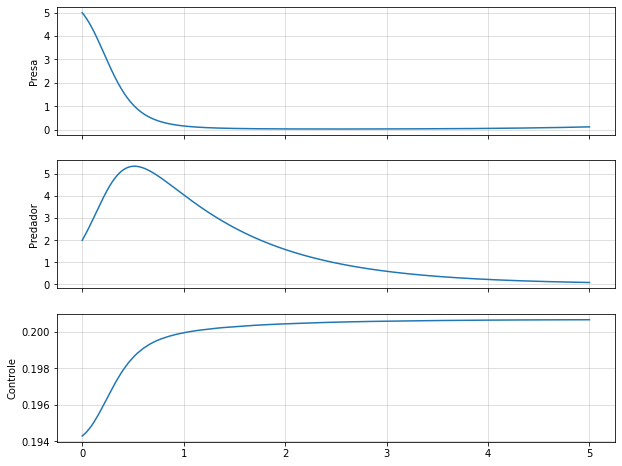

In [19]:
parameters['A'] = 10
theta = f_theta(x0, T,parameters,a,b).root
t,x,u,_ = problem.solve(x0, T, parameters, 
                              bounds = [(0, parameters['M'])], theta_list = [theta])
fig, ax = plotting(t, x, u)

Percebemos que o controle fica mais constante, enquanto as populações tem seus valores inalterados. Na verdade, variando outros parâmetros, continuamos com esse problema de variar apenas o controle, mas manter os estados essencialmente iguais. Vamos variar o valor de $T$ com essa combinação de parâmetros para encerrar. Percebemos que o uso de pesticida precisa ser mais espalhado no tempo, o que benificia um segundo pico da presa que leva consifo o pico do predador, que vem sempre após. 

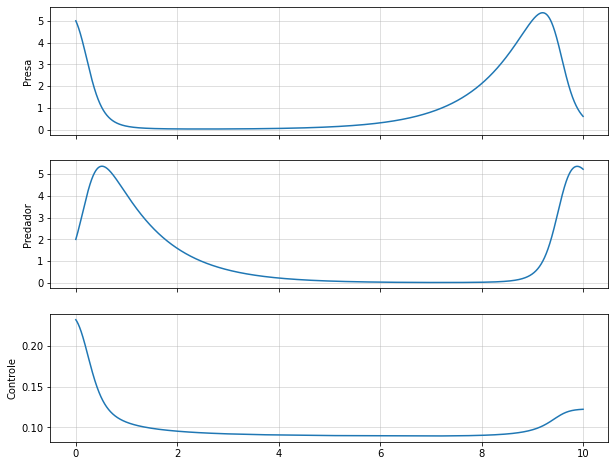

In [20]:
T = 10
theta = f_theta(x0, T,parameters,a,b).root
t,x,u,_ = problem.solve(x0, T, parameters, 
                              bounds = [(0, parameters['M'])], theta_list = [theta])
fig, ax = plotting(t, x, u)